# Анализ сервиса вопросов и ответов по программированию Stack Overflow

**Цель проекта:** с помощью SQL посчитать и визуализировать ключевые метрики сервис-системы вопросов и ответов о программировании Stack Overflow.

**Описание проекта:** написаны сложные SQL-запросы для подсчета требуемых значений и метрик.

**Данные:** данные о постах за 2008 год, причем в таблицах есть данные за более поздний период с оценками этих постов. База данных состоит из следующих таблиц:
- `badges` хранит информацию о значках, которые присуждаются за разные достижения;
- `users` содержит информацию о пользователях;
- `posts` содержит информацию о постах;
- `votes` содержит информацию о голосах за посты;
- `post_types` содержит информацию о типе постов. Их может быть два: вопрос `Question` и ответ `Answer`.
- `vote_types` содержит информацию о типах голосов. 

Голос — это метка, которую пользователи ставят посту. Типов бывает несколько: 
- `UpMod` — такую отметку получают посты с вопросами или ответами, которые пользователи посчитали уместными и полезными.
- `DownMod` — посты, которые показались пользователям наименее полезными.
- `Close` — метку ставят опытные пользователи сервиса, если заданный вопрос нужно доработать или он вообще не подходит для платформы.
- `Offensive` — если пользователь ответил на вопрос в грубой и оскорбительной манере.
- `Spam` — если пост пользователя выглядит откровенной рекламой.

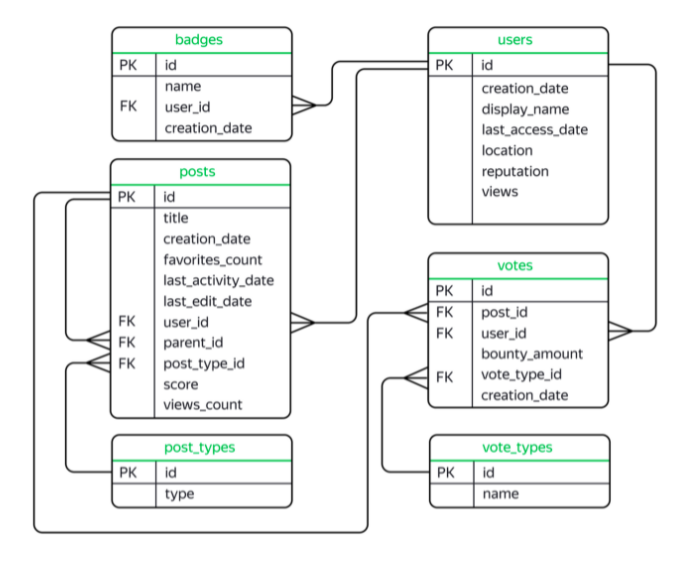

*Так как это учебный проект и база данных недоступна для работы удаленно или локально (только в тренажере Яндекс.Практикум), то подключение к БД в следующих ячейках показано исключительно для примера.*

In [1]:
# импортируем библиотеки
import pandas as pd
from sqlalchemy import text, create_engine

In [ ]:
# устанавливаем параметры
db_config = {'user': '_', # имя пользователя
            'pwd': '_', # пароль
            'host': '_',
            'port': _, # порт подключения
            'db': '_'} # название базы данных
connection_string = 'postgresql://{user}:{pwd}@{host}:{port}/{db}'.format(**db_config)

# сохраняем коннектор
engine = create_engine(connection_string, connect_args={'sslmode':'require'})

*При подключении в реальной БД можно делать запросы, используя python, следующим образом:*

In [ ]:
# чтобы выполнить SQL-запрос, используем Pandas
query = 
'''
    SELECT * 
    FROM users 
    LIMIT 100
'''
con=engine.connect()
pd.io.sql.read_sql(sql=text(query), con = con)

*В данном случае результат выполнения запроса сохранен в таблицу `sql_results.xlsx`, каждый запрос на отдельном листе. Таким образом, результат запроса, выполненный в тренажере, выводится как лист из таблицы excel.* 

Выведем общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц пропускаем. Результат отсортируем по убыванию общего количества просмотров.

In [ ]:
query = 
'''
WITH max_user AS (SELECT user_id
                FROM stackoverflow.posts
                GROUP BY user_id
                ORDER BY COUNT(user_id) DESC
                LIMIT 1),
max_posts AS (SELECT EXTRACT('week' FROM creation_date) AS week,
                    creation_date,
                    RANK() OVER (PARTITION BY EXTRACT('week' FROM creation_date) ORDER BY creation_date DESC) AS rn
            FROM stackoverflow.posts p
            JOIN max_user m ON m.user_id = p.user_id
            WHERE DATE_TRUNC('month', creation_date) BETWEEN '2008-10-01' AND '2008-10-31')
SELECT week,
    creation_date
FROM max_posts
WHERE rn=1
'''

In [3]:
# результат выполнения запроса
result = pd.read_excel('sql_results.xlsx', 'views_sum')
result

,date_trunc,sum
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Больше всего просмотров осенью, меньше всего в июле. Пик в осенние месяцы может быть связан с началом учебного года. Резкое снижение количества просмотров в июле может быть связано с неполнотой данных.

Выведем имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитываем. Для каждого имени пользователя выведем количество уникальных значений `user_id`. Результат отсортируем по полю с именами в лексикографическом порядке.

In [ ]:
query = 
'''
SELECT u.display_name, 
    COUNT(DISTINCT user_id) 
FROM stackoverflow.posts p 
JOIN stackoverflow.post_types pt ON p.post_type_id = pt.id 
JOIN stackoverflow.users u ON u.id = p.user_id 
WHERE DATE_TRUNC('day', p.creation_date) >= DATE_TRUNC('day', u.creation_date) AND 
    DATE_TRUNC('day', p.creation_date) <= DATE_TRUNC('day', u.creation_date) + INTERVAL '1 month' AND 
    pt.type = 'Answer' 
GROUP BY u.display_name 
HAVING COUNT(*) > 100 
ORDER BY display_name;
'''

In [4]:
# результат выполнения запроса
result = pd.read_excel('sql_results.xlsx', 'active_users')
result

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,aku,1
...,...,...
74,Tom,19
75,tvanfosson,1
76,tzot,1
77,Vilx-,1


Всего оказалось 79 имен, однако активных пользователей-экспертов на самом деле больше, так как некоторые имена повторяются. Поэтому анализировать стоит не по имени, а по уникальным идентификаторам пользователей.

Найдем количество постов за 2008 год по месяцам. Выберем посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Таблицу отсортируем по значению месяца по убыванию.

In [ ]:
query = 
'''
SELECT DATE_TRUNC('month', p.creation_date)::date,
    COUNT(*)
FROM stackoverflow.posts p
WHERE DATE_TRUNC('day', p.creation_date)::date BETWEEN '2008-01-01' AND '2008-12-31'
    AND user_id IN
    (SELECT user_id
    FROM stackoverflow.users u
    JOIN stackoverflow.posts p ON p.user_id = u.id
    WHERE DATE_TRUNC('day', u.creation_date)::date BETWEEN '2008-09-01' AND '2008-09-30'
        AND DATE_TRUNC('day', p.creation_date)::date BETWEEN '2008-12-01' AND '2008-12-31')
GROUP BY DATE_TRUNC('month', p.creation_date)::date
ORDER BY DATE_TRUNC('month', p.creation_date)::date DESC
'''

In [5]:
# результат выполнения запроса
result = pd.read_excel('sql_results.xlsx', '2008_posts')
result

,date_trunc,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Здесь важно отметить, что обнаружены 32 пользователя, которые были зарегистрированы в сентябре, но якобы сделали посты в августе. Это указывает на ошибку в данных.

Используя данные о постах, выведем несколько полей:
- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице отсортируем по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [ ]:
query = 
'''
SELECT user_id,
    creation_date,
    views_count,
    SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts
ORDER BY 1, 2
'''

In [6]:
# результат выполнения запроса
result = pd.read_excel('sql_results.xlsx', 'user_post')
result

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
195,5,2008-09-11 05:12:42,1469,75605
196,5,2008-09-11 07:35:43,0,75605
197,5,2008-09-11 08:21:49,0,75605
198,5,2008-09-12 16:01:55,0,75605


Для подобных расчетов удобно использовать оконные фнукции.

Узнаем, сколько в среднем дней в период с 1 по 7 декабря 2008 года включительно пользователи взаимодействовали с платформой. Для каждого пользователя отберем дни, в которые он или она опубликовали хотя бы один пост.

In [ ]:
query = 
'''
WITH s AS (SELECT user_id,
    COUNT(DISTINCT(DATE_TRUNC('day', creation_date)::date)) AS u_cnt
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
GROUP BY user_id)
SELECT ROUND(AVG(u_cnt))
FROM s
'''

In [7]:
# результат выполнения запроса
result = pd.read_excel('sql_results.xlsx', 'users_dec_2008')
result

,round
0,2


Таким образом, пользователи взаимодействуют с платформой в среднем 2 дня в неделю. 

Узнаем, на сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года. Отобразим таблицу со следующими полями:
- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. 
При делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, делимое переведем в тип numeric.

In [ ]:
query = 
'''
SELECT EXTRACT(MONTH FROM creation_date::date),
    COUNT(*) AS posts_cnt,
    ROUND(((COUNT(*)::numeric - LAG(COUNT(*)) OVER (ORDER BY EXTRACT(MONTH FROM creation_date::date))) * 100.0 / LAG(COUNT(*)) OVER (ORDER BY EXTRACT(MONTH FROM creation_date::date))), 2)
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'
GROUP BY EXTRACT(MONTH FROM creation_date::date)
'''

In [8]:
# результат выполнения запроса
result = pd.read_excel('sql_results.xlsx', 'posts_growth')
result

,date_part,posts_cnt,round
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


С сентября по декабрь 2008 года количество постов стабильно уменьшалось, наибольшее снижение - на 25% - произошло с октября по ноябрь.

Выгрузим данные активности пользователя, который опубликовал больше всего постов за всё время, за октябрь 2008 года:
- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [ ]:
query = 
'''
WITH max_user AS (SELECT user_id
                FROM stackoverflow.posts
                GROUP BY user_id
                ORDER BY COUNT(user_id) DESC
                LIMIT 1),
max_posts AS (SELECT EXTRACT('week' FROM creation_date) AS week,
                    creation_date,
                    RANK() OVER (PARTITION BY EXTRACT('week' FROM creation_date) ORDER BY creation_date DESC) AS rn
            FROM stackoverflow.posts p
            JOIN max_user m ON m.user_id = p.user_id
            WHERE DATE_TRUNC('month', creation_date) BETWEEN '2008-10-01' AND '2008-10-31')
SELECT week,
    creation_date
FROM max_posts
WHERE rn=1
'''

In [9]:
# результат выполнения запроса
result = pd.read_excel('sql_results.xlsx', 'active_user_weeks')
result

,week,creation_date
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01


Таким образом, в исходных данных обнаружены некоторые ошибки, например, посты пользователей в августе, хотя они зарегистрировались только в сентябре. Не хватает данных за июль 2008. В целом, наблюдается небольшая сезонность в опубликовании постов на сервисе: осенью пользователи более активно задают вопросы. В среднем в 2008 году пользователи взаимодействовали с сервисом Stack Overflow 2 дня в неделю.